In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('Train_SU63ISt.csv')
test=pd.read_csv('Test_0qrQsBZ.csv')
train_copy=train.copy()
test_copy=test.copy()

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
#lest look at the data
train.dtypes ,test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [5]:
train.shape , test.shape

((18288, 3), (5112, 2))

In [6]:
#convert to time
train['Datetime']=pd.to_datetime(train['Datetime'] , format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test['Datetime'] , format='%d-%m-%Y %H:%M')
train_copy['Datetime']=pd.to_datetime(train_copy['Datetime'] , format='%d-%m-%Y %H:%M')
test_copy['Datetime']=pd.to_datetime(test_copy['Datetime'] , format='%d-%m-%Y %H:%M')


In [7]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [8]:
#lets get y,m,d from each datset
for i in (train,train_copy,test,test_copy):
    i['Year']=i['Datetime'].dt.year
    i['Month']=i['Datetime'].dt.month
    i['Day']=i['Datetime'].dt.day
    i['Hour']=i['Datetime'].dt.hour
    

In [9]:
#lets see the result
train.tail()

,ID,Datetime,Count,Year,Month,Day,Hour
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22
18287,18287,2014-09-25 23:00:00,534,2014,9,25,23


### Lets see the effect of weekend on the traffic

In [10]:
train['weekday']=train['Datetime'].dt.dayofweek
train['weekend']=[1 if x in (5,6) else 0 for x in train['weekday']]

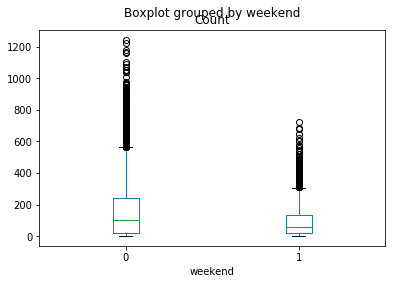

In [11]:
train.boxplot(by='weekend',column='Count',grid=False)

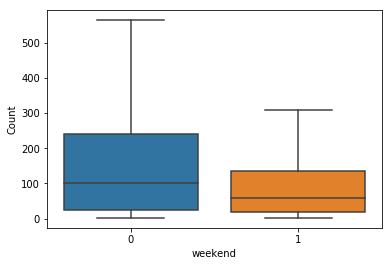

In [12]:
sns.boxplot(x='weekend',y='Count',data=train,showfliers=False)

## lets see the trend

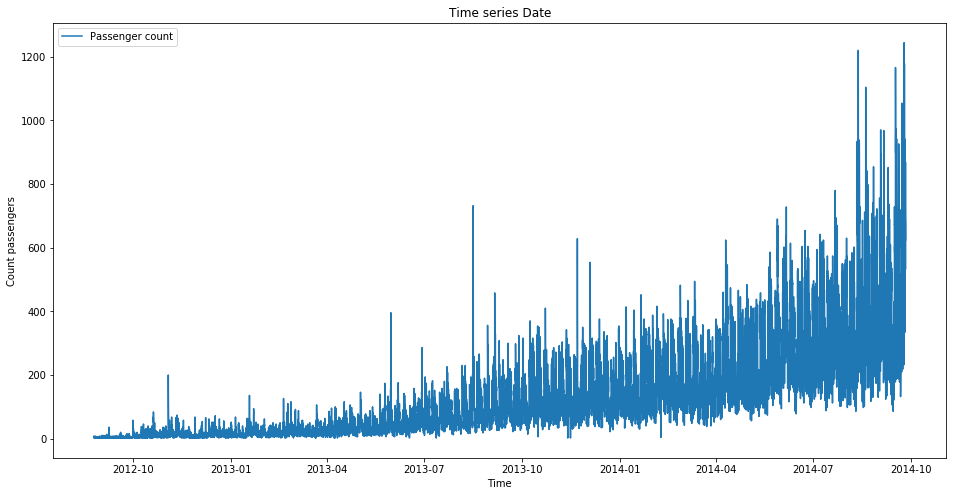

In [13]:
train.index=train['Datetime']
train.drop('ID',inplace=True,axis=1)
figure(figsize=(16,8))
plot(train['Count'],label='Passenger count')
title('Time series Date')
xlabel('Time')
ylabel('Count passengers')
legend(loc='best')
show()

### List of Hypotesis:
### *Traffic will increase as the years pass by
###  *Traffic will be high from May to October
###  *Traffic on weekdays will be more
###  *Traffic during the peak hours will be high

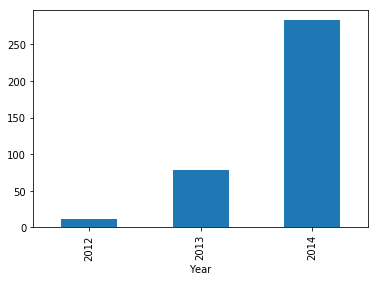

In [14]:
### *Traffic will increase as the years pass by
train.groupby('Year')['Count'].mean().plot.bar()


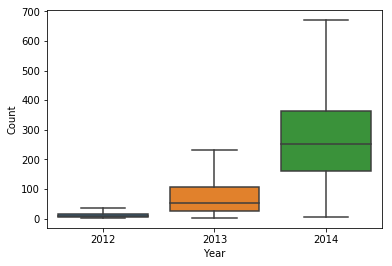

In [15]:
#more statistical compariosn!
sns.boxplot(x='Year' , y='Count' ,data=train,showfliers=False)

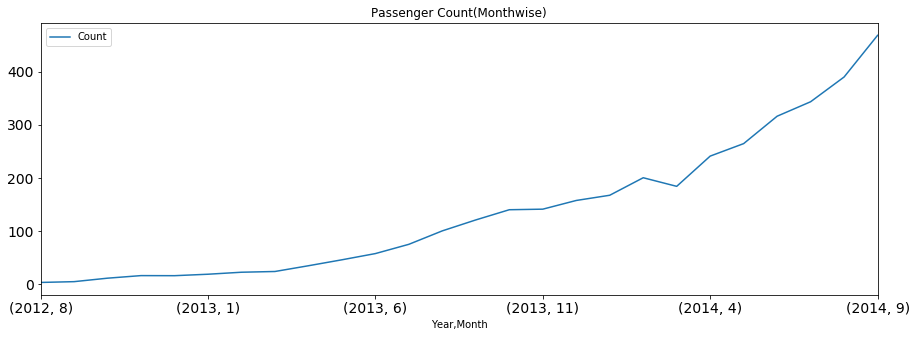

In [16]:
###  *Traffic will be high from May to October
#train.groupby('Month')['Count'].mean().plot.bar()
# this seems incorrect as the average previous years affects so:
temp=train.groupby(['Year','Month'])['Count'].mean()
temp=pd.DataFrame(temp)
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

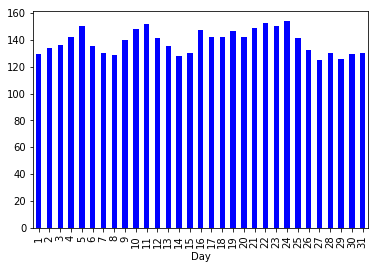

In [17]:
train.groupby('Day')['Count'].mean().plot.bar(color='b')

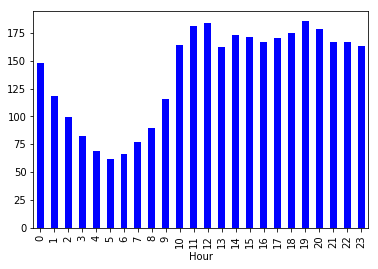

In [18]:
#it seems days do not have a good insight on the hypothesis so lets see Hours
train.groupby('Hour')['Count'].mean().plot.bar(color='b')

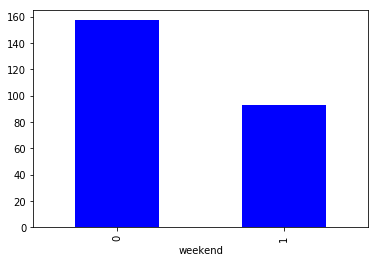

In [19]:
#lets see weekday affect on traffice
train.groupby('weekend')['Count'].mean().plot.bar(color='b')


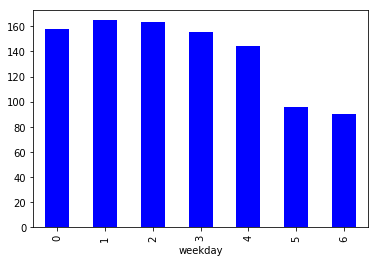

In [20]:
train.groupby('weekday')['Count'].mean().plot.bar(color='b')

In [21]:
# lets aggreagte times to bigger intervals to have a better insight
hourly=train.resample('H').mean()
Daily=train.resample('D').mean()
Weekly=train.resample('W').mean()
Montly=train.resample('M').mean()

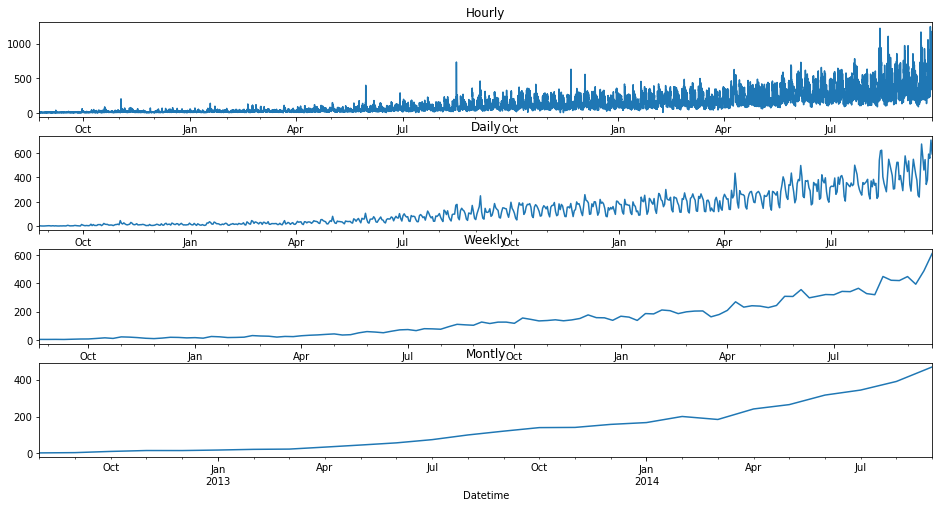

In [22]:
#lets visulaize them
fig ,axs=subplots(4,1)
hourly.Count.plot(figsize=(16,8) ,title='Hourly',ax=axs[0])
Daily.Count.plot(figsize=(16,8) ,title='Daily',ax=axs[1])
Weekly.Count.plot(figsize=(16,8) ,title='Weekly',ax=axs[2])
Montly.Count.plot(figsize=(16,8) ,title='Montly',ax=axs[3])




In [23]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean()

#### lets create validation and Train set 
#### last 3 month will be in the validation because if we choose randomly in validation set it means predict old data based 
#### on future that is meaningless so for timebased dataset we use this 

In [24]:
Train=train.ix['2012-08-25':'2014-06-24']
Valid=train.ix['2014-06-25':'2014-09-25']


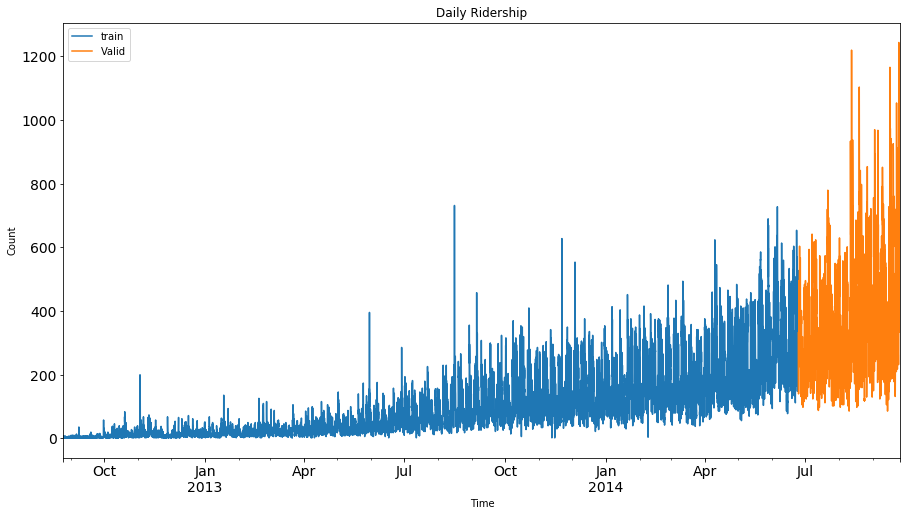

In [25]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
Valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='Valid')
xlabel('Time')
ylabel('Count')
legend(loc='best')
show()

## lets dive into the forecasting models
#### i) Naive Approach
#### ii) Moving Average
#### iii) Simple Exponential Smoothing
#### iv) Holt’s Linear Trend Model

In [26]:
#### i) Naive Approach
# put the latest count for other points
dd=np.asanyarray(Train.Count)
y_hat=Valid.copy()
y_hat['naive']=dd[len(dd)-1]

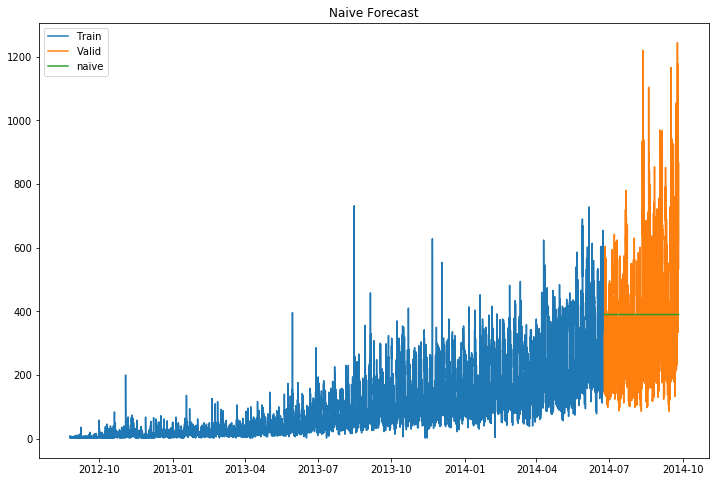

In [27]:
#lets visualize the data 
figure(figsize=(12,8))
plot(Train.index , Train.Count ,label='Train')
plot(Valid.index , Valid.Count ,label='Valid')
plot(y_hat.index , y_hat.naive ,label='naive')
legend(loc='best') 
title("Naive Forecast") 
show()


In [28]:
Train.tail()

,Datetime,Count,Year,Month,Day,Hour,weekday,weekend
Datetime,,,,,,,,
2014-06-24 19:00:00,2014-06-24 19:00:00,398,2014,6,24,19,1,0
2014-06-24 20:00:00,2014-06-24 20:00:00,444,2014,6,24,20,1,0
2014-06-24 21:00:00,2014-06-24 21:00:00,406,2014,6,24,21,1,0
2014-06-24 22:00:00,2014-06-24 22:00:00,352,2014,6,24,22,1,0
2014-06-24 23:00:00,2014-06-24 23:00:00,390,2014,6,24,23,1,0


In [29]:
#lets calculate rsme
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme=sqrt(mean_squared_error(y_hat.Count,y_hat.naive))
print(rsme)

186.37368520699056


#### ii) Moving Average


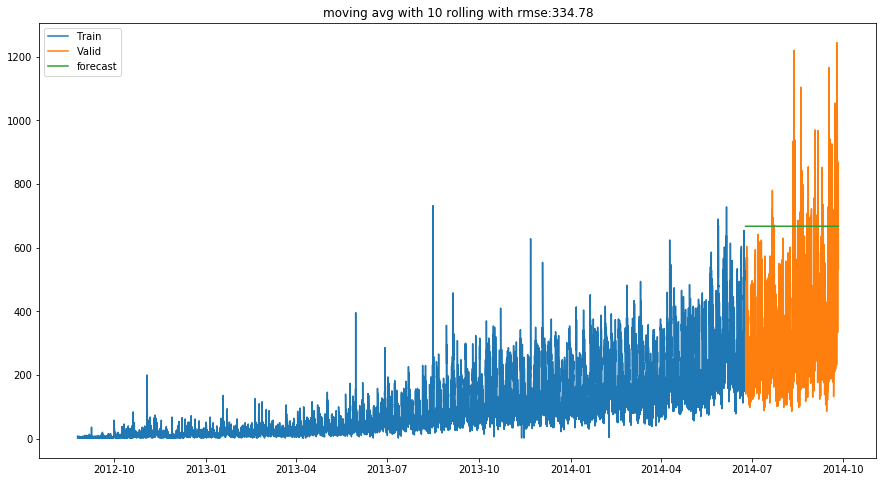

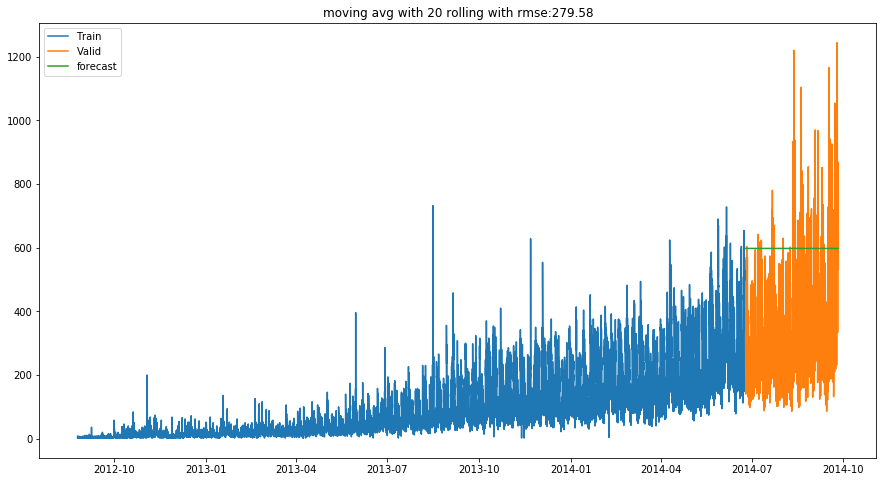

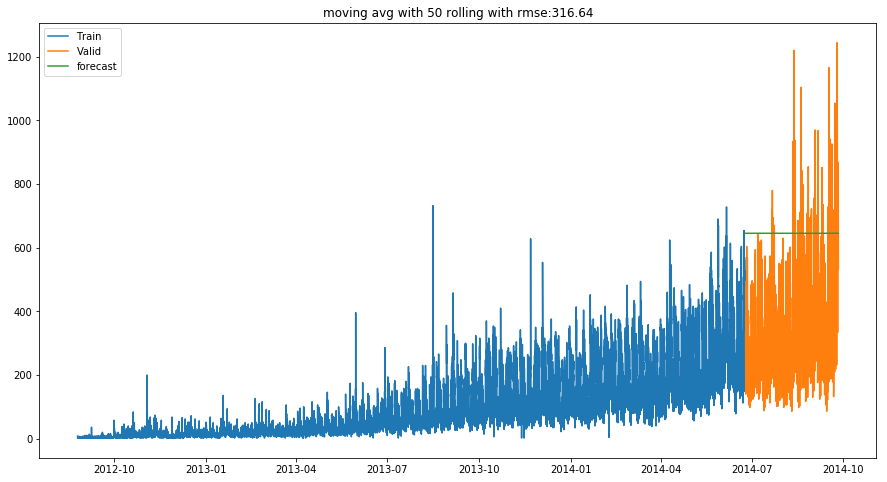

In [30]:
y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(10).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
figure(figsize=(15,8))
plot(Train.index,Train.Count,label='Train')
plot(Valid.index,Valid.Count,label='Valid')
plot(y_hat_avg.avg_forecast,label='forecast')
legend(loc='Best')
title('moving avg with 10 rolling with rmse:{}'.format(round(rmse,2)))
show()


y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(20).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
figure(figsize=(15,8))
plot(Train.index,Train.Count,label='Train')
plot(Valid.index,Valid.Count,label='Valid')
plot(y_hat_avg.avg_forecast,label='forecast')
legend(loc='Best')
title('moving avg with 20 rolling with rmse:{}'.format(round(rmse,2)))
show()


y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(50).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
figure(figsize=(15,8))
plot(Train.index,Train.Count,label='Train')
plot(Valid.index,Valid.Count,label='Valid')
plot(y_hat_avg.avg_forecast,label='forecast')
legend(loc='Best')
title('moving avg with 50 rolling with rmse:{}'.format(round(rmse,2)))
show()

iii) Simple Exponential Smoothing¶


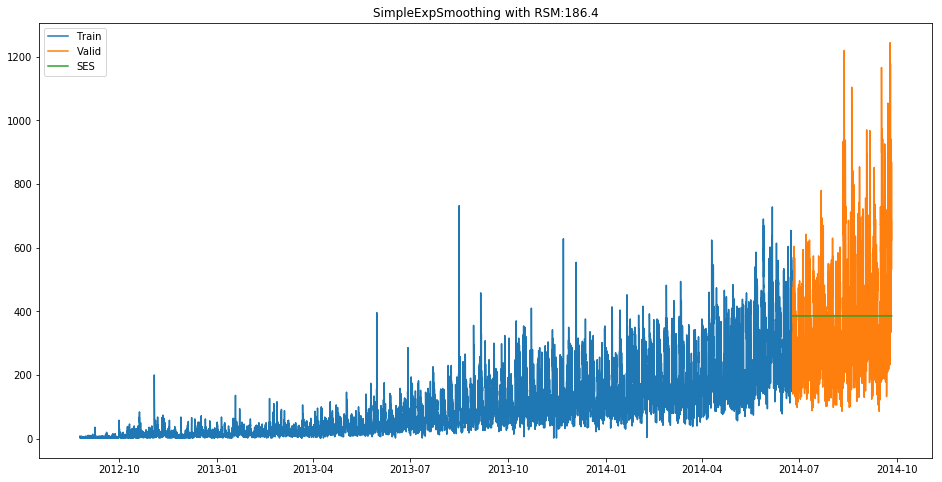

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg=Valid.copy()
fit2=SimpleExpSmoothing(np.array(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES']=fit2.forecast(len(Valid))
rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['SES'])) ,1)

figure(figsize=(16,8))
plot(Train['Count'], label='Train')
plot(Valid['Count'], label='Valid')
plot(y_hat_avg['SES'], label='SES')
title('SimpleExpSmoothing with RSM:{}'.format(rmse))
legend(loc='Best')
show()

iv) Holt’s Linear Trend Model

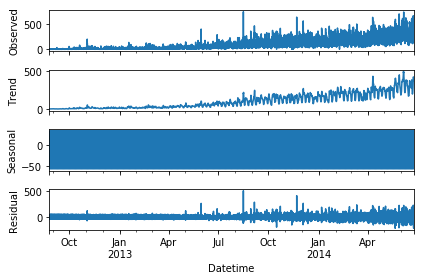

In [32]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result=sm.tsa.adfuller(train.Count) 
show()

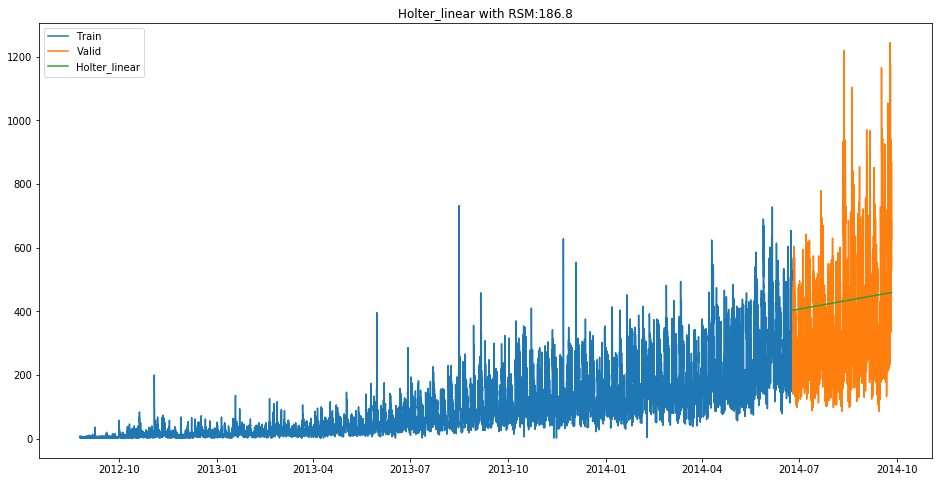

In [33]:
y_hat_avg=Valid.copy()
fit1=Holt(np.array(Train.Count)).fit(smoothing_level=0.3 )
y_hat_avg['Holter_linear']=fit1.forecast(len(Valid))

rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['Holter_linear'])) ,1)

figure(figsize=(16,8))
plot(Train['Count'], label='Train')
plot(Valid['Count'], label='Valid')
plot(y_hat_avg['Holter_linear'], label='Holter_linear')
title('Holter_linear with RSM:{}'.format(rmse))
legend(loc='Best')
show()

In [34]:
y_hat_avg.tail()

,Datetime,Count,Year,Month,Day,Hour,weekday,weekend,Holter_linear
Datetime,,,,,,,,,
2014-09-25 19:00:00,2014-09-25 19:00:00,868,2014,9,25,19,3,0,459.179613
2014-09-25 20:00:00,2014-09-25 20:00:00,732,2014,9,25,20,3,0,459.204628
2014-09-25 21:00:00,2014-09-25 21:00:00,702,2014,9,25,21,3,0,459.229642
2014-09-25 22:00:00,2014-09-25 22:00:00,580,2014,9,25,22,3,0,459.254657
2014-09-25 23:00:00,2014-09-25 23:00:00,534,2014,9,25,23,3,0,459.279672


In [35]:
submission=pd.read_csv('Sample_Submission_QChS6c3.csv')

#lets predict on test data set
predict=fit1.forecast(len(test))
test['prediction']=predict

In [36]:
#calculate the ratio of passenger count for each hour of every day
train_copy['ratio']=train_copy['Count']/train_copy['Count'].sum()
train_copy.head()

,ID,Datetime,Count,Year,Month,Day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [37]:
#the average ratio of passenger count for every hour and we will get 24 ratios
temp=train_copy.groupby('Hour')['ratio'].sum()
temp.head()
# Groupby to csv format 
pd.DataFrame(temp,columns=['Hour','ratio']).to_csv('Groupby.csv')
temp2=pd.read_csv('Groupby.csv')
temp2.drop('Hour.1',1, inplace=True)
temp2.head()


,Hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802


In [38]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test,test_copy,on=('Day','Month','Year'),how='left')
merge['Hour']=merge['Hour_y']
merge.drop(['Year','Month','Datetime','Hour_x','Hour_y'],axis=1,inplace=True)
merge.head()

,ID_x,Day,prediction,ID_y,Hour
0,18299.5,26.0,403.472134,18288,0
1,18299.5,26.0,403.472134,18289,1
2,18299.5,26.0,403.472134,18290,2
3,18299.5,26.0,403.472134,18291,3
4,18299.5,26.0,403.472134,18292,4


In [39]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge,temp2,on='Hour',how='left')
prediction.head()

,ID_x,Day,prediction,ID_y,Hour,ratio
0,18299.5,26.0,403.472134,18288,0,0.044287
1,18299.5,26.0,403.472134,18289,1,0.035343
2,18299.5,26.0,403.472134,18290,2,0.029911
3,18299.5,26.0,403.472134,18291,3,0.024714
4,18299.5,26.0,403.472134,18292,4,0.020802


In [40]:
# Converting the ratio to the original scale
prediction['count']=prediction['prediction'] * prediction['ratio']*24
prediction['ID']=prediction['ID_y']
prediction.drop(['ID_x','Day','prediction','ratio','Hour','ID_y'], axis=1, inplace=True)
prediction.head()

,count,ID
0,428.841699,18288
1,342.238111,18289
2,289.638854,18290
3,239.318237,18291
4,201.434884,18292


In [41]:
# upload data 
prediction.to_csv('Holter_linear.csv',columns=['ID','count'],index=False)
# Got 640 rms in leader board 

In [42]:
prediction.head()

,count,ID
0,428.841699,18288
1,342.238111,18289
2,289.638854,18290
3,239.318237,18291
4,201.434884,18292


 4) Holt winter’s model on daily time series

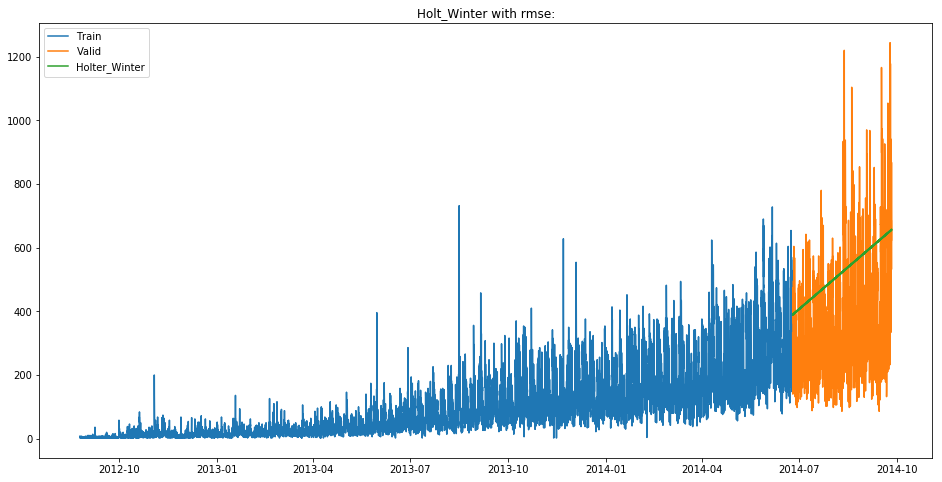

In [43]:
y_hat_avg=Valid.copy()
fit1=ExponentialSmoothing(np.array(Train['Count']),seasonal_periods=7 , trend='add' , seasonal='add').fit()
y_hat_avg['Holter_Winter'] = fit1.forecast(len(Valid))
rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['Holter_Winter'])) ,1)

figure(figsize=(16,8))
plot(Train['Count']  ,label='Train')
plot(Valid['Count']  ,label='Valid')
plot(y_hat_avg['Holter_Winter']  ,label='Holter_Winter')
title('Holt_Winter with rmse:'.format(rmse))
legend(loc='Best')
show()

 Expand to the test dataset

In [44]:
predict=fit1.forecast(len(test))
test['prediction']=predict

In [45]:
test.head()

,ID,Year,Month,Day,Hour,prediction
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,388.890927
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,389.482911
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,389.891881
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,390.156827
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,391.549597


In [46]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test,test_copy,on=('Day','Month','Year'),how='left')
merge.head()

,ID_x,Year,Month,Day,Hour_x,prediction,ID_y,Datetime,Hour_y
0,18299.5,2014.0,9.0,26.0,11.5,388.890927,18288,2014-09-26 00:00:00,0
1,18299.5,2014.0,9.0,26.0,11.5,388.890927,18289,2014-09-26 01:00:00,1
2,18299.5,2014.0,9.0,26.0,11.5,388.890927,18290,2014-09-26 02:00:00,2
3,18299.5,2014.0,9.0,26.0,11.5,388.890927,18291,2014-09-26 03:00:00,3
4,18299.5,2014.0,9.0,26.0,11.5,388.890927,18292,2014-09-26 04:00:00,4


In [47]:
merge['Hour']=merge['Hour_y']
merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1,inplace=True)
merge.head()

,ID_x,Day,prediction,ID_y,Hour
0,18299.5,26.0,388.890927,18288,0
1,18299.5,26.0,388.890927,18289,1
2,18299.5,26.0,388.890927,18290,2
3,18299.5,26.0,388.890927,18291,3
4,18299.5,26.0,388.890927,18292,4


In [48]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left')
prediction['Count']=prediction['prediction'] * prediction['ratio'] * 24
prediction.head()

,ID_x,Day,prediction,ID_y,Hour,ratio,Count
0,18299.5,26.0,388.890927,18288,0,0.044287,413.343653
1,18299.5,26.0,388.890927,18289,1,0.035343,329.869860
2,18299.5,26.0,388.890927,18290,2,0.029911,279.171504
3,18299.5,26.0,388.890927,18291,3,0.024714,230.669440
4,18299.5,26.0,388.890927,18292,4,0.020802,194.155165


In [49]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['Day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)
submission.head()

,Count,ID
0,413.343653,18288
1,329.869860,18289
2,279.171504,18290
3,230.669440,18291
4,194.155165,18292


In [50]:
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv',index=False)

### Parameter tuning for ARIMA model

In [51]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
    # #Determing rolling statistics

    rolmean= pd.Series(timeseries).rolling(window=24).mean()
    rolstd = pd.Series(timeseries).rolling(window=24).std()

    #plot the
    orig= plot(timeseries,color='Blue' ,label='Original')
    mean=plot(rolmean , color = 'red' , label = 'rolling mean')
    std=plot(rolstd , color = 'black' , label='rolling std' )
    legend('best')
    title('Rolling Mean & std ')

    show(block=False)

    # eprform adfuller test
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries , autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key , val in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = val
    print(dfoutput)

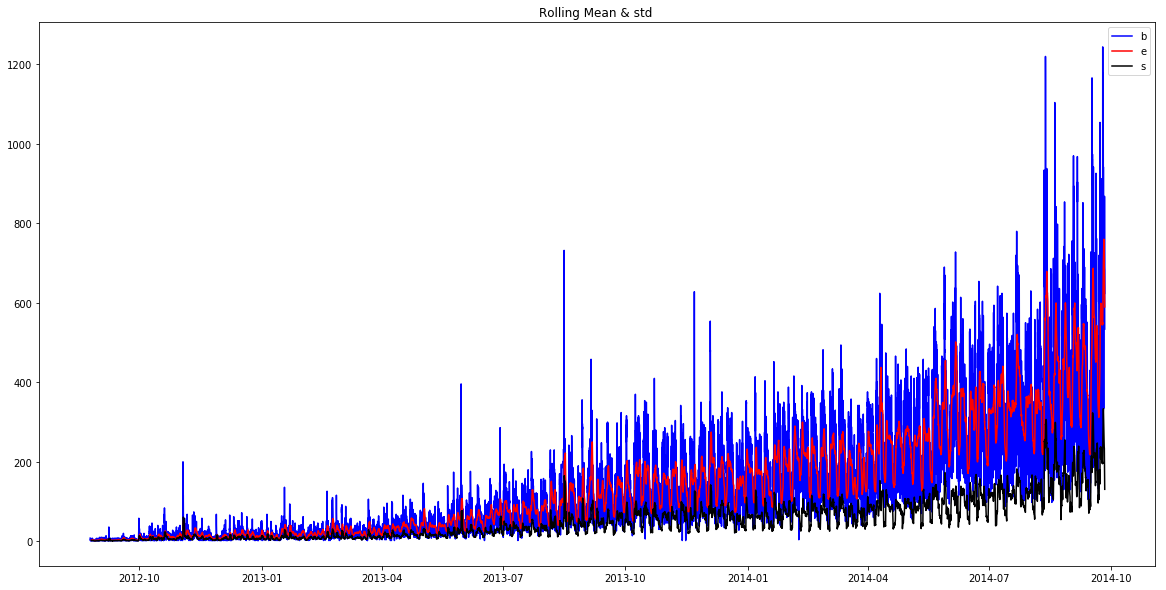

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
test_stationary(train['Count'])

## Removing Trend


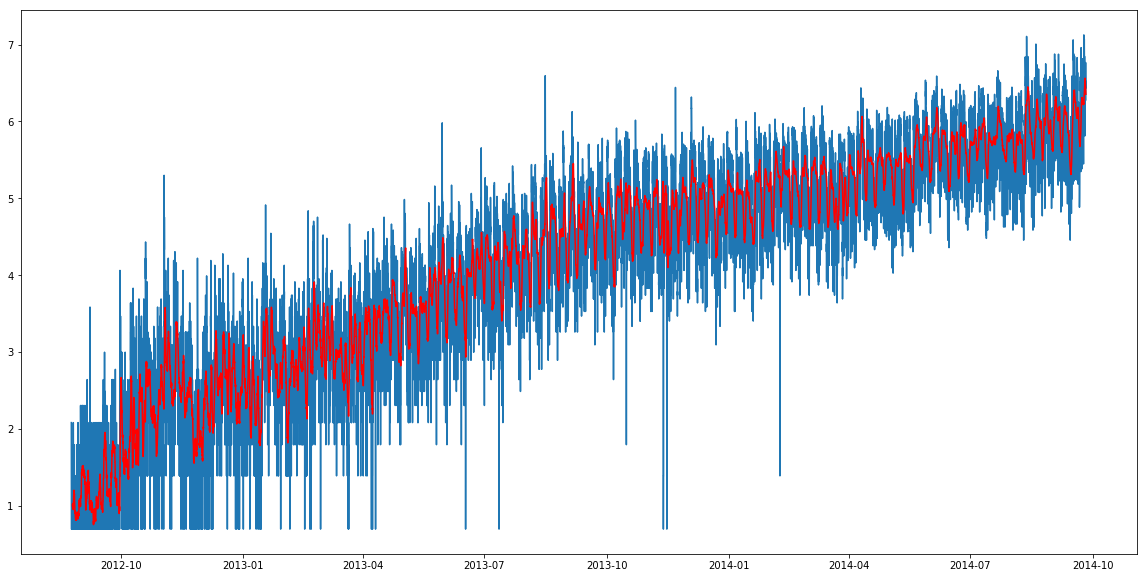

In [53]:
train_log=np.log(train['Count'])
valid_log=np.log(Valid['Count'])


moving_avg=pd.Series(train_log).rolling(window=24).mean()
# plot the average
plot(train_log)
plot(moving_avg,color='red')
show()

In [54]:
# we see trend so we neglect the trend by differnce log and moving avg
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.head(25)
train_log_moving_avg_diff.shape

(18288,)

In [55]:
# as we see there is null vals for the previous 23 h so we remove NULLS
train_log_moving_avg_diff.dropna(inplace=True)
train_log_moving_avg_diff.shape

(18265,)

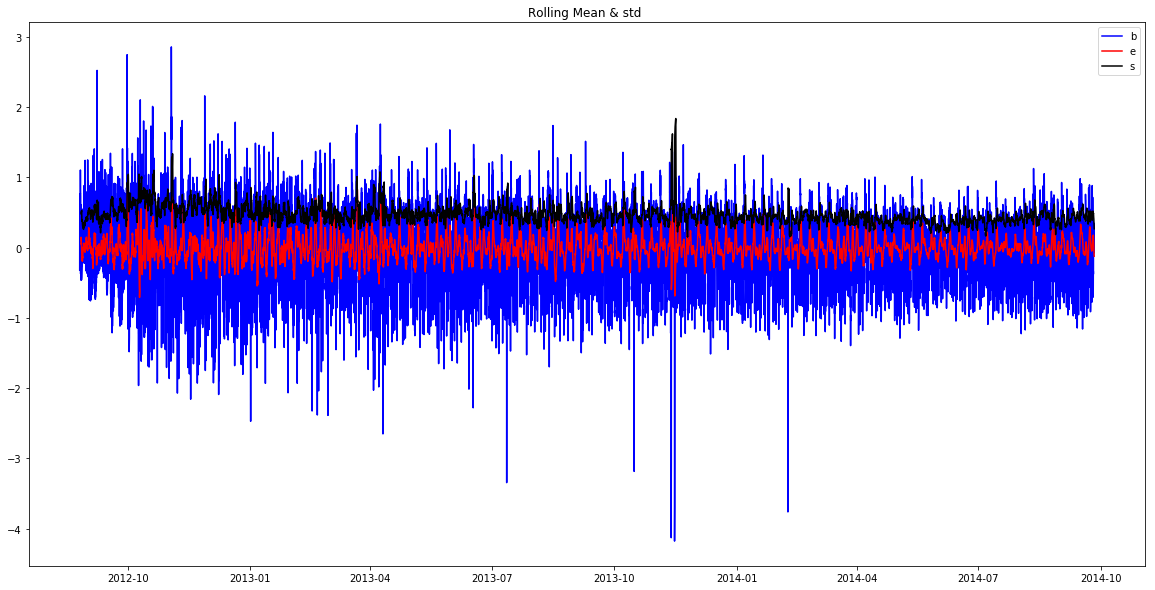

Results of Dickey-Fuller Test:
Test Statistic                   -21.316940
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18219.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861699
Critical Value (10%)              -2.566854
dtype: float64


In [56]:
test_stationary(train_log_moving_avg_diff)

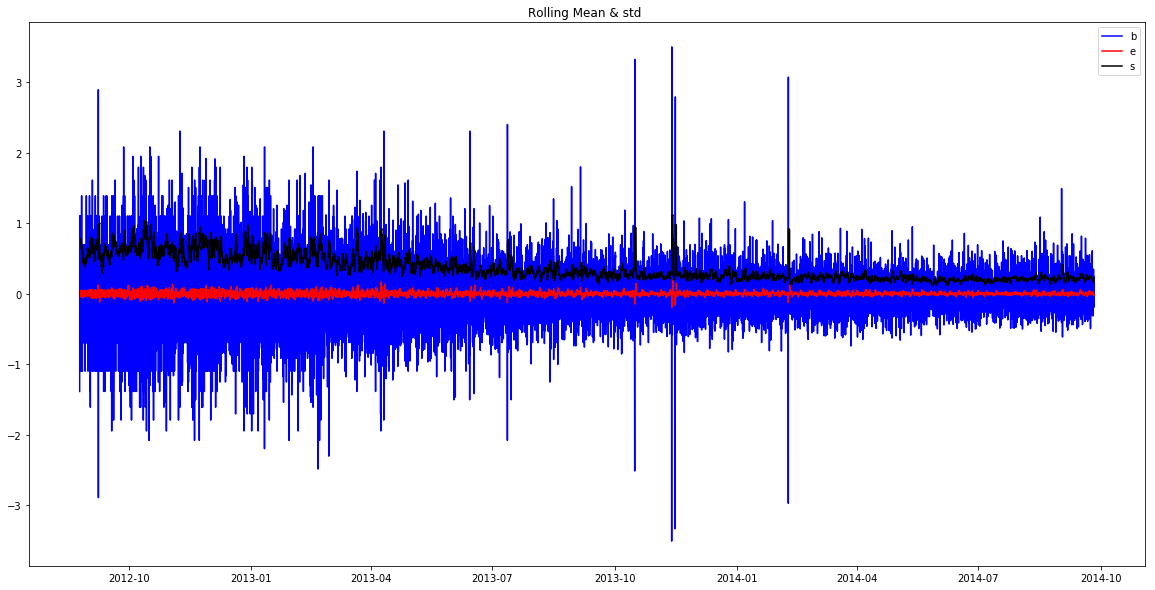

Results of Dickey-Fuller Test:
Test Statistic                   -32.041628
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18241.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [57]:
train_log_diff = train_log - train_log.shift(1)
test_stationary(train_log_diff.dropna())

### Removing Seasonality


In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [59]:
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values , freq=24)

In [60]:
trend=decomposition.trend
sesonal = decomposition.seasonal
residual = decomposition.resid


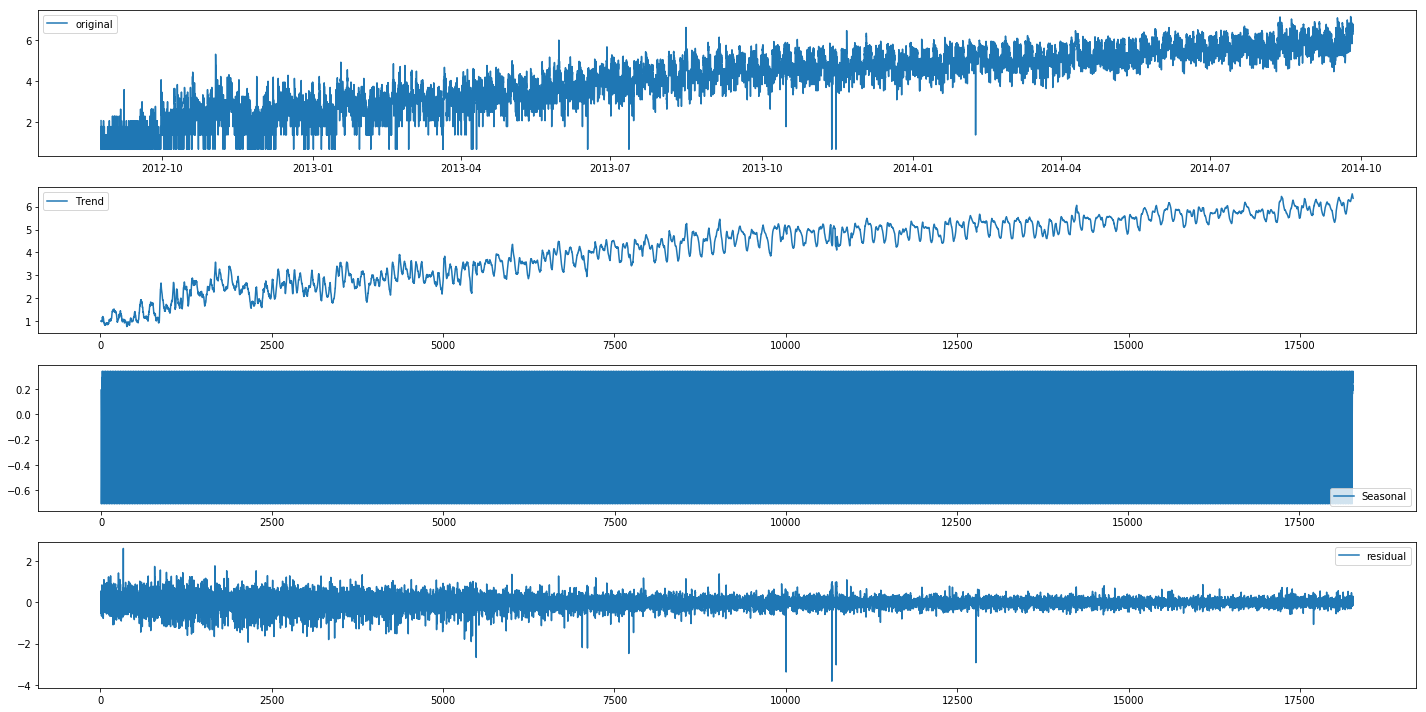

In [61]:
subplot(411)
plot(train_log , label ='original')
legend(loc='best') 
subplot(412)
plot(trend , label ='Trend')
legend(loc='best') 
subplot(413)
plot(sesonal , label ='Seasonal')
legend(loc='best') 
subplot(414)
plot(residual , label ='residual')
legend(loc='best') 
tight_layout() 
show()

In [62]:
train_log_decompose=pd.DataFrame(residual)

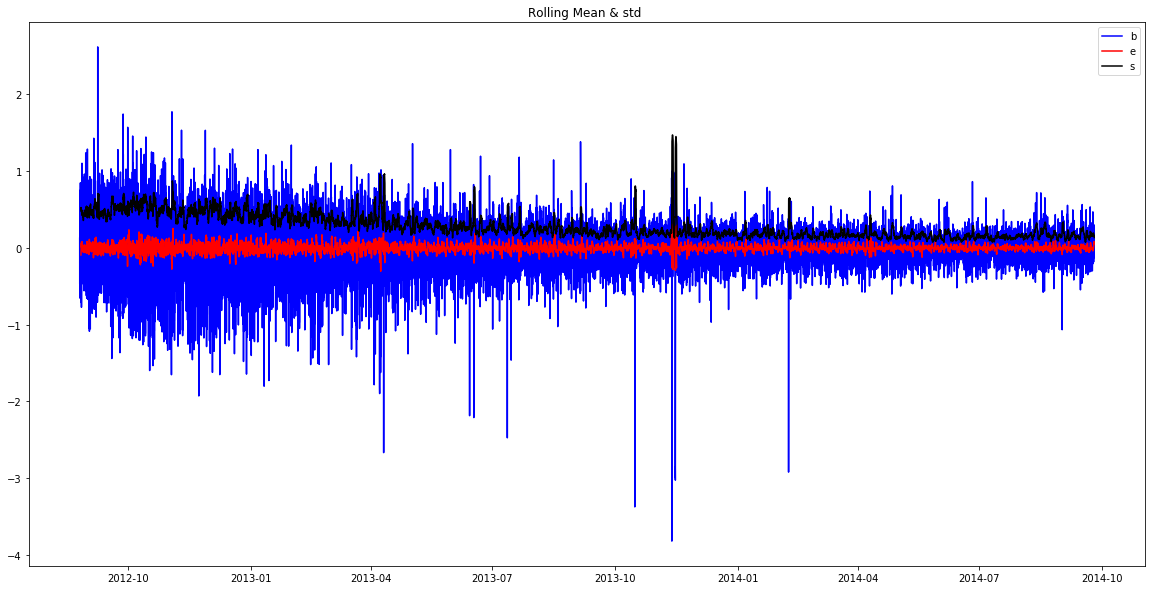

Results of Dickey-Fuller Test:
Test Statistic                   -32.205683
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18218.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861699
Critical Value (10%)              -2.566854
dtype: float64


In [63]:
train_log_decompose['date']=train_log.index
train_log_decompose.set_index('date' , inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationary(train_log_decompose[0])

### Forecasting the time series using ARIMA

To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

** ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

** PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.


In [64]:

from statsmodels.tsa.stattools import acf , pacf


In [65]:
lag_acf = acf(train_log_diff.dropna() , nlags=25)
lag_pacf = pacf(train_log_diff.dropna() , nlags=25 , method='ols')


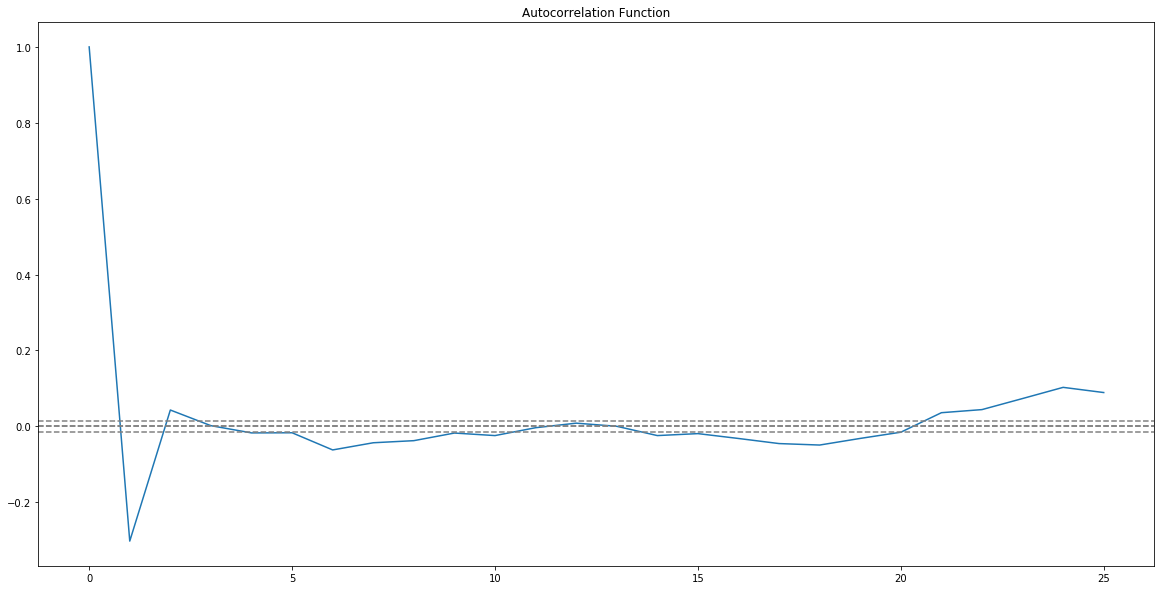

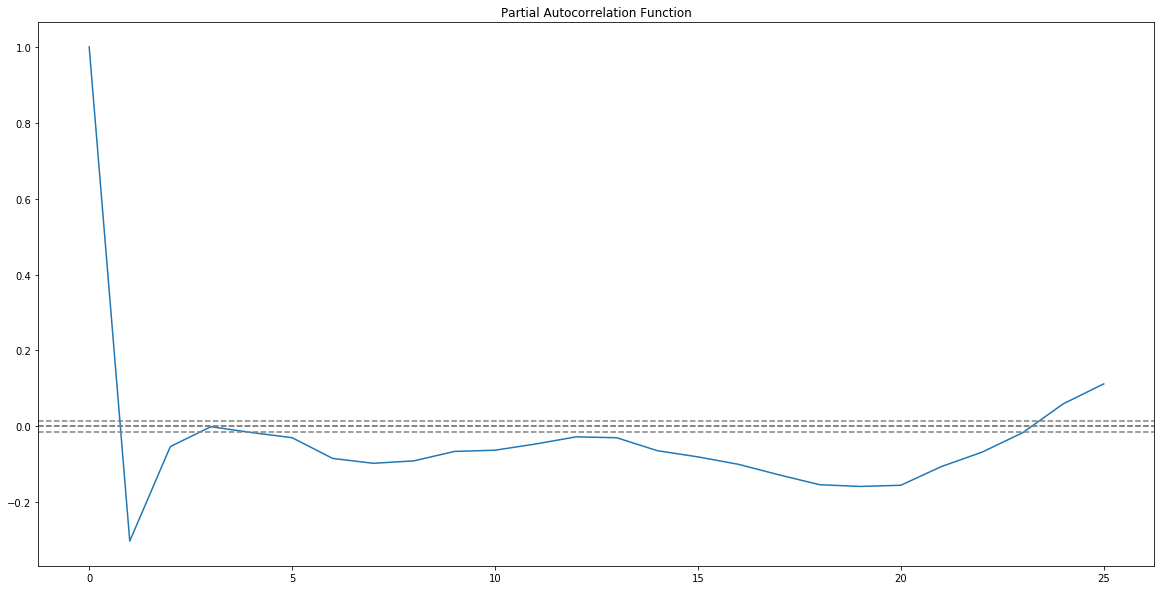

In [66]:
#ACF and PACF plot
plot(lag_acf)
axhline(y=0 ,linestyle ='--' , color='gray')
axhline(y=0 ,linestyle ='--' , color='gray')
axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
title('Autocorrelation Function')
show()

plot(lag_pacf)
axhline(y=0 ,linestyle ='--' , color='gray')
axhline(y=0 ,linestyle ='--' , color='gray')
axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
title('Partial Autocorrelation Function')
show()



### AR model


In [67]:
from statsmodels.tsa.arima_model import ARIMA

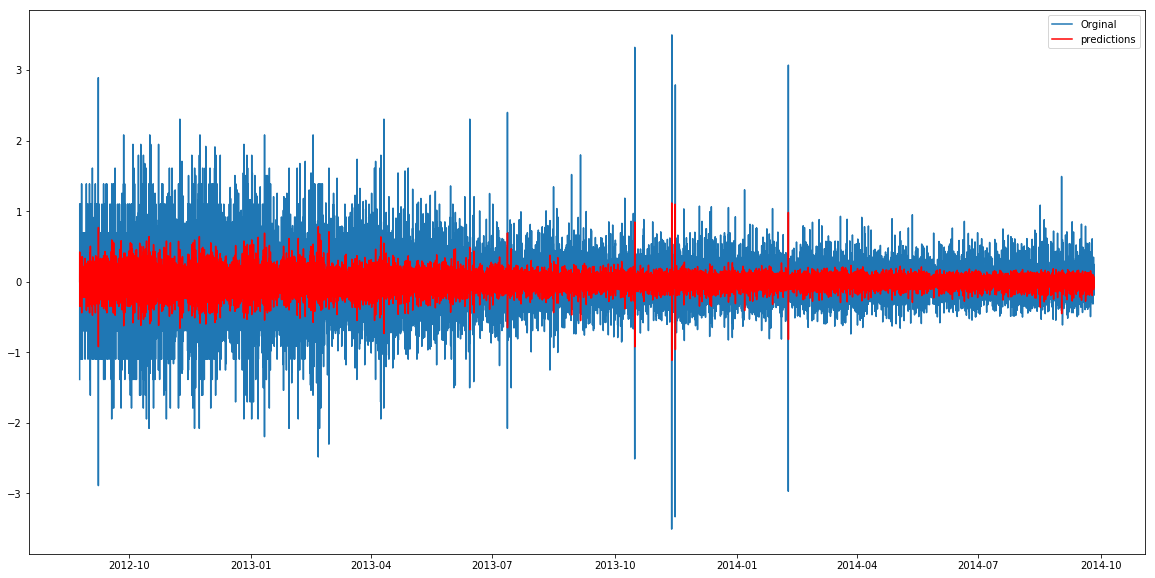

In [68]:
model = ARIMA(train_log , order=(2,1,0)) # here the q value is zero since it is just the AR model 
results_AR= model.fit(disp=-1)
plot(train_log_diff.dropna() , label='Orginal')
plot(results_AR.fittedvalues, color='red', label='predictions')
legend(loc='best')
show()


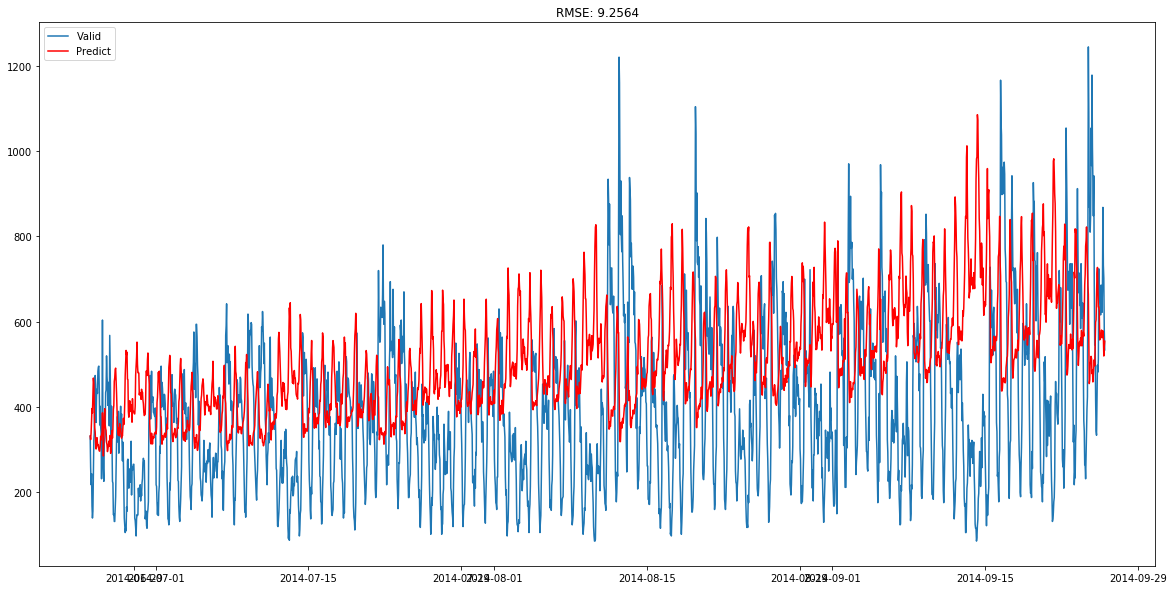

In [69]:
AR_predict = results_AR.predict(start = "2014-06-25", end="2014-09-25")
AR_predict = AR_predict.cumsum().shift().fillna(0)

AR_predict1 = pd.Series(np.ones(Valid.shape[0]) *  np.log(Valid['Count'])[0] , index =Valid.index)
AR_predict1 = AR_predict1.add(AR_predict , fill_value=0)
AR_predict = np.exp(AR_predict1)


plot(Valid['Count'] ,label='Valid')
plot(AR_predict , color= 'red' , label='Predict')
legend(loc='best')
title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, Valid['Count']))/Valid.shape[0]))
show()



### MA model


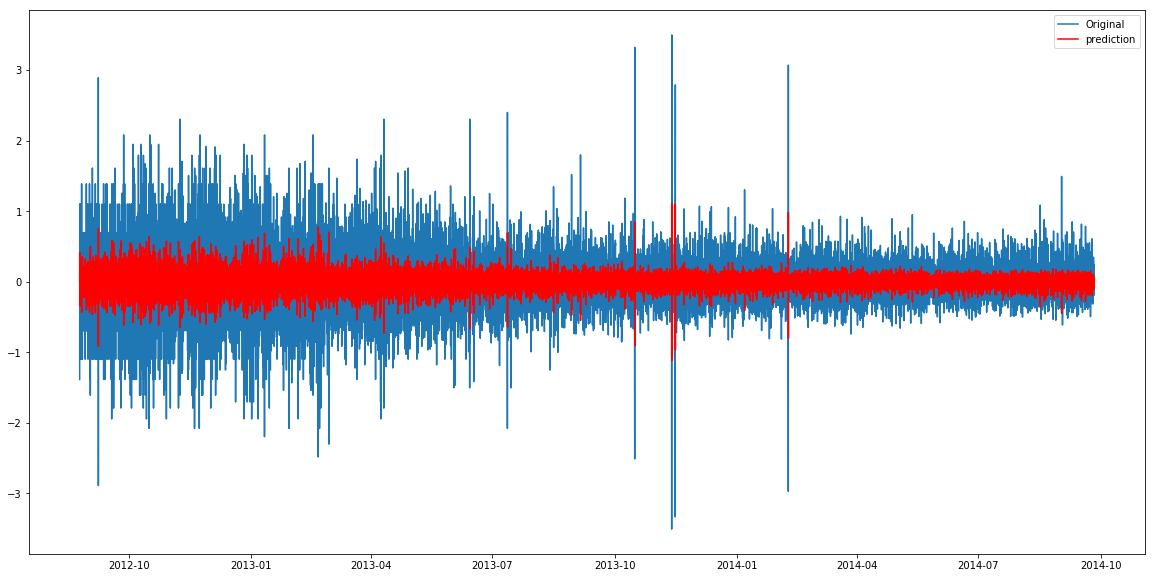

In [70]:
model = ARIMA(train_log , order=(0,1,2)) # here the p value is zero since it is just the MA model
result_MA= model.fit(disp=-1)

plot(train_log_diff.dropna() , label='Original')
plot(result_MA.fittedvalues, color='red', label='prediction' )
legend(loc='best')
show()

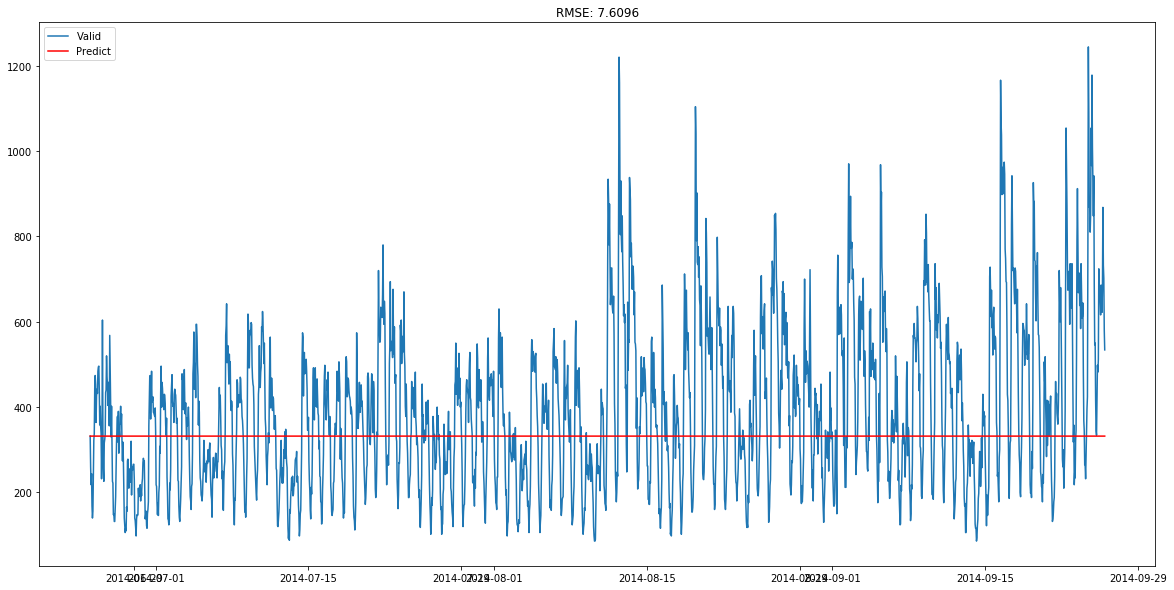

In [71]:
MA_predict = result_MA.predict(start = "2014-06-25", end="2014-09-25")
MA_predict = MA_predict.cumsum().shift().fillna(0)

MA_predict1 = pd.Series(np.ones(Valid.shape[0]) *  np.log(Valid['Count'])[0] , index =Valid.index)
NA_predict1 = MA_predict1.add(MA_predict , fill_value=0)
MA_predict = np.exp(MA_predict1)


plot(Valid['Count'] ,label='Valid')
plot(MA_predict , color= 'red' , label='Predict')
legend(loc='best')
title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, Valid['Count']))/Valid.shape[0]))
show()


### Combined Model

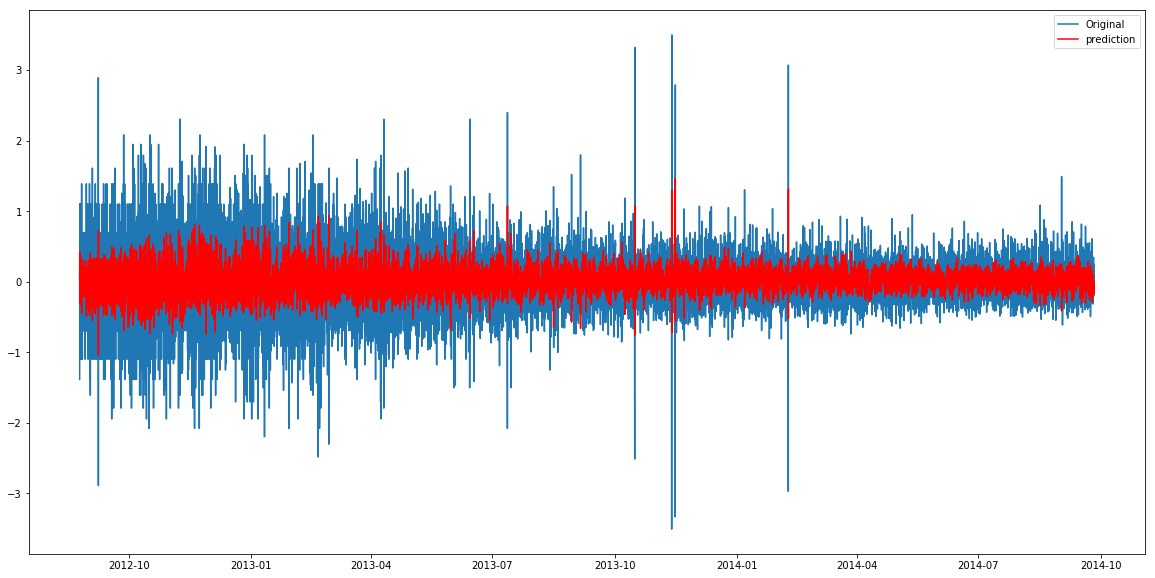

In [72]:
model = ARIMA(train_log , order=(2,1,2)) # here the p value is zero since it is just the MA model
result_ARIMA= model.fit(disp=-1)

plot(train_log_diff.dropna() , label='Original')
plot(result_ARIMA.fittedvalues, color='red', label='prediction' )
legend(loc='best')
show()

In [73]:
# Let’s define a function which can be used to change the scale of the model to the original scale.

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plot(given_set['Count'], label = "Given set")
    plot(predict, color = 'red', label = "Predict")
    legend(loc= 'best')
    title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plot(given_set['Count'], label = "Given set")
    plot(predict, color = 'red', label = "Predict")
    legend(loc= 'best')
    title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    show()

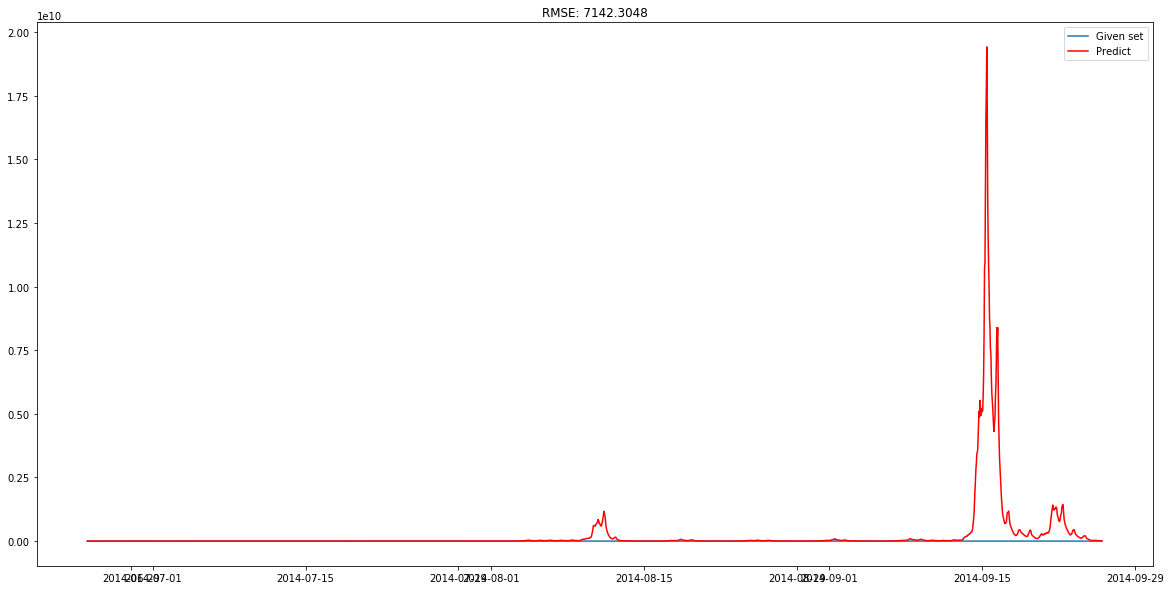

In [74]:
#Let’s predict the values for validation set.

ARIMA_predict_diff=result_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, Valid)

### 7) SARIMAX model on daily time series


In [75]:
import statsmodels.api as sm

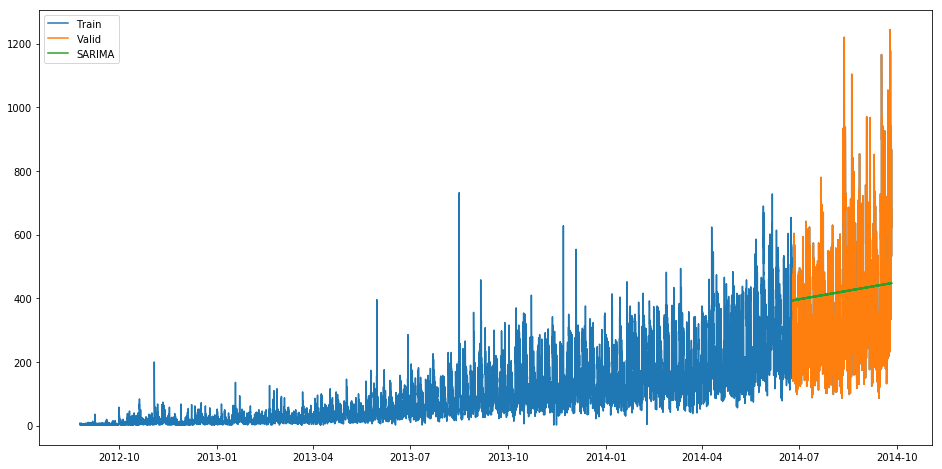

In [88]:
# y_hat_avg = Valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMAX'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True )
figure(figsize=(16,8))
plot(train['Count'] , label='Train')
plot(Valid['Count'] , label='Valid')
plot(y_hat_avg['SARIMAX'] , label='SARIMA')
legend(loc='best')
show()



In [91]:
rms = sqrt(mean_squared_error(Valid.Count, y_hat_avg.SARIMAX)) 
rsme

186.37368520699056

In [93]:
#Daily prediction
predict = fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True )


In [99]:
#Hourly predcition
test['Prediction'] = predict
merge=pd.merge(test, test_copy, on=('Day','Month', 'Year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 
# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['Day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')


In [98]:
test

,ID,Year,Month,Day,Hour,prediction,Prediction
Datetime,,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,388.890927,523.892367
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,389.482911,525.886287
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,389.891881,526.325751
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,390.156827,526.674439
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,391.549597,529.999513
...,...,...,...,...,...,...,...
2015-04-22,23291.5,2015.0,4.0,22.0,11.5,413.622585,668.237313
2015-04-23,23315.5,2015.0,4.0,23.0,11.5,412.945128,669.998231
2015-04-24,23339.5,2015.0,4.0,24.0,11.5,414.031831,669.625477
